# [Langchain RAG](https://python.langchain.com/docs/tutorials/rag/)

In [1]:
#from langchain_ollama import OllamaLLM
#llm = OllamaLLM(model="llama3.2:latest")

from langchain_ollama import ChatOllama

llm = ChatOllama(
   model="llama3.2:latest",
   temperature=0,
   # other params...
)

In [2]:
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="llama3.2:latest")

In [3]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [4]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
len(docs)

1

In [6]:
docs[0].page_content[:500]

'\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn'

In [7]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [8]:
len(all_splits)

63

In [9]:
all_splits[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refin

In [10]:
all_splits[1]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Memory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.\nLong-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.\n\n\nTool use\n\nThe agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources and more.\n\n\n\n\n\nOverview of a LLM-powered autonomous agent system.')

In [11]:
all_splits[2]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a 

In [12]:
_ = vector_store.add_documents(documents=all_splits)

great. works!

deviate from tutorial. Use [Building a RAG Application with LangChain: Example Code](https://vitalflux.com/building-llm-rag-application-langchain-example-code/#google_vignette)    to set up prompt

In [13]:
from langchain.prompts import ChatPromptTemplate
 
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [14]:
# set up state
# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_rag_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [15]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [16]:
response = graph.invoke({"question": "What is Task Decomposition?"})

In [17]:
response

{'question': 'What is Task Decomposition?',
 'context': [Document(id='ecb1bd49-1b93-4991-941c-16f7917791e7', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Resources:\n1. Internet access for searches and information gathering.\n2. Long Term memory management.\n3. GPT-3.5 powered Agents for delegation of simple tasks.\n4. File output.\n\nPerformance Evaluation:\n1. Continuously review and analyze your actions to ensure you are performing to the best of your abilities.\n2. Constructively self-criticize your big-picture behavior constantly.\n3. Reflect on past decisions and strategies to refine your approach.\n4. Every command has a cost, so be smart and efficient. Aim to complete tasks in the least number of steps.'),
  Document(id='6a635182-4069-4227-b150-401bd92eb10e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Resources:\n1. Internet access for searches and information gathering.\n2. Long Term 

In [18]:
for step in graph.stream({"question": "What is Task Decomposition?"}, stream_mode="updates"):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='ecb1bd49-1b93-4991-941c-16f7917791e7', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Resources:\n1. Internet access for searches and information gathering.\n2. Long Term memory management.\n3. GPT-3.5 powered Agents for delegation of simple tasks.\n4. File output.\n\nPerformance Evaluation:\n1. Continuously review and analyze your actions to ensure you are performing to the best of your abilities.\n2. Constructively self-criticize your big-picture behavior constantly.\n3. Reflect on past decisions and strategies to refine your approach.\n4. Every command has a cost, so be smart and efficient. Aim to complete tasks in the least number of steps.'), Document(id='6a635182-4069-4227-b150-401bd92eb10e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Resources:\n1. Internet access for searches and information gathering.\n2. Long Term memory management.\n3. GPT-3.5 po

# Query Analysis

In [19]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'section': 'beginning'}

In [20]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
x = vector_store.add_documents(all_splits)

In [21]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [22]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

In [26]:
from langchain.prompts import ChatPromptTemplate
 
template = """Answer the question based only on the following context:
{context}
 
Question: {question}
"""
 
prompt = ChatPromptTemplate.from_template(template)

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

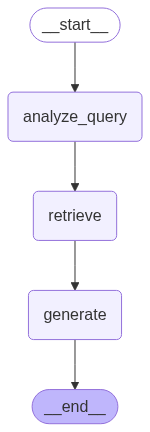

In [27]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='fe36d63e-7540-436d-bfd0-f72627aacef4', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adjust plans when faced w

In [29]:
for step in graph.stream(
    {"question": "What does the beginning of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='f04d5b62-3345-4dac-bae8-a425e939879c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'beginning'}, page_content='MRKL (Karpas et al. 2022), short for “Modular Reasoning, Knowledge and Language”, is a neuro-symbolic architecture for autonomous agents. A MRKL system is proposed to contain a collection of “expert” modules and the general-purpose LLM works as a router to route inquiries to the best suitable expert module. These modules can be neural (e.g. deep learning models) or symbolic (e.g. math calculator, currency converter, weather API).\nThey did an experiment on fine-tuning LLM to call a calculator, using arithmetic as a test case. Their experiments showed that it was harder to solve verbal math problems than explicitly stated math problems because LLMs (7B Jurassic1-large model) failed to extract t

ok. so analyze query calls with "Search" as the method. Search pulls out the query and the section. Retrieve then gets things that match only that section and
uses them as context for the final search.